In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers

from keras.utils.vis_utils import plot_model

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/data_100_pct_undersample/"

Using TensorFlow backend.


# Load Data

In [2]:
# Load from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("data_100_pct_undersample/train_user_logs_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)

In [3]:
X_user_logs = np.load(temp_path)
print(X_user_logs.shape)
print(X_user_logs[0][0][0:10])

(24798, 762, 7)
[2.43421435e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.15294003e-06]


In [4]:
X_members = pd.read_csv(INPUT_PATH + "X_train_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y = pd.read_csv(INPUT_PATH + "y_train.csv", header=None).sort_values(0).drop([0],axis=1).values

In [5]:
num_members_cols = X_members.shape[1]
num_members_cols

27

# Multi Input Example

In [6]:
batch_size = 128
epochs = 5
lstm_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

combined = concatenate([a_mod.output, b_mod.output])

c = Dropout(0.2)(combined)
c = Dense(1, activation='softmax')(c)

model = Model(inputs=[a_mod.input, b_mod.input], outputs=c)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit([X_user_logs, X_members], y, batch_size=batch_size, epochs=epochs,verbose=1)


Epoch 1/5
24798/24798 [==============================] - 78s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 2/5
24798/24798 [==============================] - 75s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 3/5
24798/24798 [==============================] - 76s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 4/5
24798/24798 [==============================] - 76s 3ms/step - loss: 7.6481 - accuracy: 0.5012
Epoch 5/5
24798/24798 [==============================] - 79s 3ms/step - loss: 7.6481 - accuracy: 0.5012


In [8]:
# Try just the member features
batch_size = 128
epochs = 5

num_members = X_user_logs.shape[0]
num_member_cols = X_members.shape[1]

data_in_b = Input(shape = (num_member_cols,))
x = Dense(16, activation='relu')(data_in_b)
x = Dense(1, activation='softmax')(x)

model = Model(inputs=data_in_b, outputs=x)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit(X_members, y, batch_size=batch_size, epochs=epochs,verbose=1)


Epoch 1/5
24798/24798 [==============================] - 0s 19us/step - loss: 7.6481 - accuracy: 0.5012
Epoch 2/5
24798/24798 [==============================] - 0s 11us/step - loss: 7.6481 - accuracy: 0.5012
Epoch 3/5
24798/24798 [==============================] - 0s 11us/step - loss: 7.6481 - accuracy: 0.5012
Epoch 4/5
24798/24798 [==============================] - 0s 11us/step - loss: 7.6481 - accuracy: 0.5012
Epoch 5/5
24798/24798 [==============================] - 0s 10us/step - loss: 7.6481 - accuracy: 0.5012


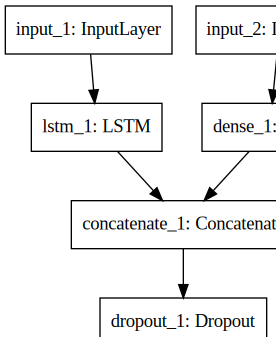

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))